# Massplane before pairing

**Motivation:** In the `Background-Sculpting-Cuts` notebook, I was trying to unfold the analysis cuts one by one to see the impact that they have on sculpting the background. However, when writing out the TTrees from the RDataFrames, I need access to the HCs. 

I feel like the conclusion from these plots was that the sculpting was already noticable right after the pairing, so we're really just trying to figure out at what step this is happening. 

My suspicion is it's coming from $D_{hh}$, so this notebook is going to try to demonstrate that by starting from the mini-Ntuple and going through the first cuts in the analysis.

I'll continue until I have done the pairing selection, so at this point I'll have a validation step where I can compare results from the `afterPairing` tree that I'm printing out with Beojean's code, and my implementation.

I think I'll write this notebook with two options that lets me run over data or mc.


In [1]:
from root_numpy import root2array 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from GraphNN.utils import calcMinDr

import ROOT
from ROOT import TLorentzVector, TVector3

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Welcome to JupyROOT 6.14/04


### Which sample to run over

So I want this notebook to be able to run over either the SM NR or the  2015 data. So to do this, I'm going to let the `subDir` flag steer which sample I'm going to run over, and it will also take care of saving the output figures to separate subdirectories.

In [2]:
subDir = 'SM_NR'
run_one = True

I'm also going to want to use different color maps for the figures to make it super clear later on when looking at thees exactly what I was doing!

In [3]:
c_lead = 'rebeccapurple'
c_subl = 'navy'

figDir = "figures/"+subDir

if subDir == 'SM_NR':
    
    mc = True
    
    cmap_m  = "BuPu"
    cmap_dr = "RdPu"
    c_evt = 'C4'
        
    title = "SM NR"
    
    fDir = "/eos/user/h/hartman/hh4b/SMNR/user.bstanisl.HH4B.450000.SM_HH.MC16a-2015-2016.AB21.2.61-FEB2019-Prod.pflow_vr-systs-resolved_MiniNTuple.root/"
    if run_one:
        fName = "user.bstanisl.17142219._000001.MiniNTuple.root" # for lower stats
        microName = "SM_NR_01.root"
    else:
        fName = "user.bstanisl.17142219._000*.MiniNTuple.root"
        microName = "SM_NR.root"
    
elif subDir == 'data_15':
    
    mc = False
    
    cmap_m  = "YlGnBu"
    cmap_dr = "Blues"

    c_evt = 'k'
    
    title = "data 2015"
    
    fDir = "/eos/user/m/mproffit/public/hh4b/user.bstanisl.HH4B.2018-04-30T0908Z.data15-rel21_MiniNTuple.root/"
    if run_one:
        fName = "user.bstanisl.13910752._000001.MiniNTuple.root"
    else:
        fName = "user.bstanisl.13910752._000*.root"
    microName = "data_15.root"
else:
    print("Error: Don't have functionality to run over",subDir)

Load in the miniNtuple

In [4]:
myFiles = fDir + fName

treeName = "XhhMiniNtuple"

branches = ['nresolvedJets',
            'resolvedJets_E',
            'resolvedJets_pt',
            'resolvedJets_phi',
            'resolvedJets_eta',
            'resolvedJets_MV2c10',
            'resolvedJets_HadronConeExclTruthLabelID',
            'resolvedJets_is_MV2c10_FixedCutBEff_70',
            'nmuon','muon_pt','muon_eta',
            'muon_phi','muon_m','muon_EnergyLoss']

mc_branches = ['resolvedJets_SF_MV2c10_FixedCutBEff_70','mcChannelNumber','mcEventWeight']

if mc: branches += mc_branches

dfs = []
sum_weights_initial = 0

for i, myFile in enumerate(glob.glob(myFiles)[:50]):

    print('{}. {}\n'.format(i+1,myFile))
    
    evtNum = root2array(myFile, treeName,branches='eventNumber')#,selection='nresolvedJets >= 4')
    
    arr = root2array(myFile, treeName,branches=branches)#,selection='nresolvedJets >= 4')
    df = pd.DataFrame(arr,index=evtNum,columns=branches)
    dfs.append(df)

    # Also open the metadata to get the sum of the mc event weights
    f = ROOT.TFile.Open(myFile)
    metadata = f.Get("MetaData_EventCount_XhhMiniNtuple")
    sum_weights_initial += metadata.GetBinContent(3)
    
miniNtuple = pd.concat(dfs)

1. /eos/user/h/hartman/hh4b/SMNR/user.bstanisl.HH4B.450000.SM_HH.MC16a-2015-2016.AB21.2.61-FEB2019-Prod.pflow_vr-systs-resolved_MiniNTuple.root/user.bstanisl.17142219._000001.MiniNTuple.root



In [5]:
# test_df = pd.DataFrame(root2array(myFile, treeName))
# for c in test_df.columns:
#     print()

## Step 1: Loop over the events, and select the jets leading in b-tag discriminant

At this point we have $4 \choose 2$, or 3 pairings, so I think I should add some new columns to the df where I just write all of these down so that I can plot them.

Also note, the HCs should at this point be sorted by the scalar sum of their constituents.

In [6]:
miniNtuple['4jets_m4j'] = 0
miniNtuple['mc_sf'] = 0 if mc else 1

for pair in [0,1,2]:
    for HC in [1,2]:
        for var in ['m','dRjj']:
            key = 'pair{}_HC{}_{}'.format(pair,HC,var)
            miniNtuple[key] = 0

        
# For data, set the mc branches to 1 since these are branches that you don't need
# to access
if not mc:
    for b in mc_branches:
        miniNtuple[b] = 1

**Side note: Deriving the MC weights**

When I started making plots from Beojean's framework, I was using for the weights what he had in the `mc_sf` column of the RDataframe. I'll need to recreate this logic in the code to form the corresponding weighted histograms at this stage of the analysis.


In [7]:
for ib in range(1,metadata.GetNbinsX()+1):
    print(ib,metadata.GetXaxis().GetBinLabel(ib),metadata.GetBinContent(ib))

1 nEvents initial 40000.0
2 nEvents selected 40000.0
3 sumOfWeights initial 1104.8629251862897
4 sumOfWeights selected 1104.8629251862897
5 sumOfWeightsSquared initial 162.46391610609396
6 sumOfWeightsSquared selected 162.46391610609396


Just as Beojean indicated, the sum_weights_initial bin indicates is in bin 3 of the Ntuple.

Ok, so this sum_weights_intial is *not* the end of the story. This is just the sum of all of the weights in the miniNtuple (Max was saying before any of the selections that are made in XhhCommon).

But we also need to fold in 
- the luminosity to normalize to
- the cross section
- the k-factor
- the generator filter efficiency

Beojean does this around L486 of `resolved_recon.cpp`, and all I need to figure out is **how to get the xsec, k_factor, and gen_filter_eff from the db_entry**!

The db_entry is a .tsv file, but it looks like you can put read a .tsv file with `pd.read_csv()`

In [8]:
tsvFile = "../../hh4b-resolved-reconstruction/mc-config/xsec.tsv"

# To figure out the format of the .tsv file, I looked at Beojean's MCConfig.cpp file.
db_cols = ['physics_short','xsec','gen_filter_eff','k_factor','rel_uncert_up','rel_uncert_down','generator']
db_entry = pd.read_csv(tsvFile,sep='\t \t|\t\t',index_col=0,engine='python',names=db_cols)

db_entry['xsec'] *= 1000

In [9]:
db_entry.head()

physics_short          xsec  gen_filter_eff  \
110351         PowhegPythia_P2012_ttbar_allhad  6.955500e+05         0.45171   
110401      PowhegPythia_P2012_ttbar_nonallhad  6.955400e+05         0.54855   
110910     Pythia8_AU2MSTW2008LO_zprime3000_tt  5.662200e+00         1.00000   
119994  Pythia8_A2MSTW2008LO_minbias_inelastic  7.842000e+13         1.00000   
147400            PowhegPythia8_AZNLO_Wplusenu  1.131500e+07         1.00000   

        k_factor  rel_uncert_up  rel_uncert_down  \
110351       1.0            0.0              0.0   
110401       1.0            0.0              0.0   
110910       1.0            0.0              0.0   
119994       1.0            0.0              0.0   
147400       1.0            0.0              0.0   

                                            generator  
110351  Powheg+Pythia(v6.427)+Tauola(v27feb06)+Photos  
110401  Powheg+Pythia(v6.427)+Tauola(v27feb06)+Photos  
110910                                Pythia8(v8.183)  
119994                                Pythia8(v8.186)  
147400                Powheg+Pythia8(v8.183)+Photospp

From this information, I should be able to derive the sample weight for the event.

Beojean accesses the attributes using the mc channel number.

In [10]:
# Normalize to the 2015 data rn, but this doesn't really matter for this study
lumi = 3.2

if mc:

    chanNums = np.unique(miniNtuple.mcChannelNumber)
    i_mc = chanNums[0].astype(int)

    sample_weight = lumi 
    sample_weight *= db_entry.loc[i_mc,"xsec"] 
    sample_weight *= db_entry.loc[i_mc,"k_factor"] 
    sample_weight *= db_entry.loc[i_mc,"gen_filter_eff"] 
    sample_weight /= sum_weights_initial
    
else:
    sample_weight = 1

In [11]:
miniNtuple.head()

nresolvedJets                                     resolvedJets_E  \
40739              2                              [677.12646, 1059.223]   
40163              3                   [798.3063, 574.86237, 300.39264]   
41060              4        [332.30634, 159.15305, 59.98805, 40.633472]   
40442              4         [162.84279, 193.44376, 93.52923, 36.31572]   
41228              5  [466.19662, 543.2707, 265.7253, 182.87335, 115...   

                                         resolvedJets_pt  \
40739                               [588.0453, 579.3407]   
40163                    [791.1165, 464.3366, 232.55708]   
41060         [147.45953, 88.04104, 56.32844, 39.388454]   
40442       [127.40005, 124.975105, 33.84356, 25.972086]   
41228  [246.36624, 155.88022, 113.32287, 40.853405, 2...   

                                        resolvedJets_phi  \
40739                            [-2.5618055, 0.6231163]   
40163                 [-2.6043737, 0.3295059, 1.1299155]   
41060        [0.927532, -1.56455, -2.5730417, 1.4593184]   
40442    [0.57681996, 3.1098607, -1.6357211, -1.2673761]   
41228  [1.1791837, -1.7850189, -2.0658934, 0.01506485...   

                                        resolvedJets_eta  \
40739                             [0.51808804, 1.205011]   
40163              [0.12467092, 0.65790606, -0.74447787]   
41060   [-1.4509578, 1.1960713, 0.29143357, -0.18117625]   
40442    [0.72739094, -1.0013676, -1.6736112, 0.8470351]   
41228  [1.2513815, 1.9191765, 1.4938614, -2.178477, 2...   

                                     resolvedJets_MV2c10  \
40739                            [0.14294185, 0.9990325]   
40163                [0.9471009, 0.9965211, -0.86409456]   
41060    [0.9529924, 0.5983589, -0.38932443, 0.95944446]   
40442    [0.9999902, 0.99818254, 0.9965793, -0.82864904]   
41228  [0.999651, -0.8264987, -0.17109534, -0.7111994...   

      resolvedJets_HadronConeExclTruthLabelID  \
40739                                  [5, 5]   
40163                               [5, 5, 0]   
41060                            [5, 5, 0, 5]   
40442                            [5, 5, 5, 0]   
41228                         [5, 0, 5, 0, 5]   

      resolvedJets_is_MV2c10_FixedCutBEff_70  nmuon      muon_pt  \
40739                                 [0, 1]      0           []   
40163                              [1, 1, 0]      1  [30.757607]   
41060                           [1, 0, 0, 1]      0           []   
40442                           [1, 1, 1, 0]      1  [25.152294]   
41228                        [1, 0, 0, 0, 1]      0           []   

            ...       pair0_HC2_m pair0_HC2_dRjj pair1_HC1_m pair1_HC1_dRjj  \
40739       ...                 0              0           0              0   
40163       ...                 0              0           0              0   
41060       ...                 0              0           0              0   
40442       ...                 0              0           0              0   
41228       ...                 0              0           0              0   

      pair1_HC2_m  pair1_HC2_dRjj  pair2_HC1_m  pair2_HC1_dRjj  pair2_HC2_m  \
40739           0               0            0               0            0   
40163           0               0            0               0            0   
41060           0               0            0               0            0   
40442           0               0            0               0            0   
41228           0               0            0               0            0   

       pair2_HC2_dRjj  
40739               0  
40163               0  
41060               0  
40442               0  
41228               0  

[5 rows x 31 columns]

In [12]:
# my_df = pd.DataFrame(root2array(myFile, treeName))
# for c in my_df.columns:
#     print(c)

In [13]:
Rmatch = 0.4
njets = 4
cols = ['resolvedJets_pt', 'resolvedJets_eta', 'resolvedJets_phi', 'resolvedJets_E',
        'resolvedJets_MV2c10', 'resolvedJets_is_MV2c10_FixedCutBEff_70',
        'resolvedJets_SF_MV2c10_FixedCutBEff_70','mcEventWeight',
        'nmuon','muon_pt','muon_eta','muon_phi','muon_m','muon_EnergyLoss']

for ievt, (jpts ,jetas, jphis, jEs, jmv2s, jtags, jsfs, mcEvtWt, 
           nmu, mu_pts, mu_etas, mu_phis, mu_ms, mu_eloss) in miniNtuple[cols].iterrows():
    
    
    # 4 b-tagged jets w/ pT > 40 GeV, |eta| < 2.5
    mask = (jpts > 40) & (np.abs(jetas) < 2.5) & (jmv2s > 0.83) #jtags

    # Select events w/ only 4 jets
    if mask.sum() < njets:
        continue
    
    # Calculate the mc sf for the event. To do this, we need to consider all of the taggable jets
    if mc:
        miniNtuple.loc[ievt,'mc_sf'] = mcEvtWt * sample_weight
        for jsf in jsfs[(jpts > 40) & (np.abs(jetas) < 2.5)]:
            miniNtuple.loc[ievt,'mc_sf'] *= jsf[0]
    
    # Sort the good jets by mv2 and take the leading 4 ones
    acc = (jpts > 40) & (np.abs(jetas) < 2.5)
    idx  = np.argsort(jmv2s[acc])[::-1][:njets]
    
    sort_pts = jpts[acc][idx]
    sort_etas = jetas[acc][idx]
    sort_phis = jphis[acc][idx]
    sort_Es = jEs[acc][idx]
    
    # With 4 jets, we can find the invariant mass
    ps = [TLorentzVector() for i in range(njets)]
    for i, (pt, eta, phi, E) in enumerate(zip(sort_pts,sort_etas,sort_phis,sort_Es)):
        ps[i].SetPtEtaPhiE(pt, eta, phi, E)
        #p4j += ps[i]
        
    # Do the muon in jet correction
    if nmu > 0:
        mus = [TLorentzVector() for i in range(nmu)]
        for i, (pt, eta, phi, m) in enumerate(zip(mu_pts,mu_etas,mu_phis,mu_ms)):
            mus[i].SetPtEtaPhiM(pt, eta, phi, m)

        # Do the matching of muons to jets
        # dr_mus distance between the jet and it's closest muon
        # imus indexes this closest muon in the list 
        dr_mus, imus = calcMinDr(ps,mus,R=Rmatch)
    
        # Add the matched muons to the jet 4-vectors
        for ij, dr, imu in zip(range(njets),dr_mus,imus):
            if dr < Rmatch:
                
                # Get the energy loss in the calorimeter
                eloss = mu_eloss[imu] / 1000. # It looks like the XhhCommon has this in MeV
                theta, phi = mus[imu].Theta(), mus[imu].Phi()
                
                v3 = TVector3()
                v3.SetMagThetaPhi(eloss, theta, phi)
                
                # Add the muon, and subtract off the expected energy loss
                ps[ij] = ps[ij] + mus[imu] - TLorentzVector(v3,eloss)

    
    # Calculate the di-higgs 4-vector 
    p4j = TLorentzVector()
    for i in range(njets):
        p4j += ps[i]
    miniNtuple.loc[ievt,'4jets_m4j'] = p4j.M()
    
    # For 4 jets, we have 3 pairings
    # At this stage, the HCs are sorted by the scalar sum of the pT of the constituents
    for pi, idx1, idx2 in zip(range(3), [(0,1),(0,2),(0,3)], [(2,3),(1,3),(1,2)]):
        
        # Calculate the scalar sum of the two HCs
        ss1 = ps[idx1[0]].Pt() + ps[idx1[1]].Pt()
        ss2 = ps[idx2[0]].Pt() + ps[idx2[1]].Pt()
        
        if ievt == 58408:
            print("ss1",ss1)
            print("ss2",ss2)
        
        # Order the pairs by the SS of the constituents
        if ss1 > ss2:
            j11, j12 = ps[idx1[0]], ps[idx1[1]]
            j21, j22 = ps[idx2[0]], ps[idx2[1]]
               
            if ievt == 58408:
                print('HC2 formed from jet {} and {}'.format(idx2[0],idx2[1]))
                
        else:
            j11, j12 = ps[idx2[0]], ps[idx2[1]]
            j21, j22 = ps[idx1[0]], ps[idx1[1]]
            
            if ievt == 58408:
                print('HC2 formed from jet {} and {}'.format(idx1[0],idx1[1]))
            
        HC1 = j11 + j12
        HC2 = j21 + j22
          
        if ievt == 58408:
            print('SS of HC1 const: {:.2f}'.format(j11.Pt() + j12.Pt()))
            print('SS of HC2 const: {:.2f}'.format(j21.Pt() + j22.Pt()))    
                        
        # Calculate the invariant mass
        miniNtuple.loc[ievt,'pair{}_HC1_m'.format(pi)] = HC1.M()
        miniNtuple.loc[ievt,'pair{}_HC2_m'.format(pi)] = HC2.M()
        
        # Calculate the opening angle between the consituents
        miniNtuple.loc[ievt,'pair{}_HC1_dRjj'.format(pi)] = j11.DeltaR(j12)
        miniNtuple.loc[ievt,'pair{}_HC2_dRjj'.format(pi)] = j21.DeltaR(j22)

ss1 207.895560220626
ss2 166.46056747436523
HC2 formed from jet 2 and 3
SS of HC1 const: 207.90
SS of HC2 const: 166.46
ss1 132.33236976042093
ss2 242.0237579345703
HC2 formed from jet 0 and 2
SS of HC1 const: 242.02
SS of HC2 const: 132.33
ss1 190.42777152433695
ss2 183.9283561706543
HC2 formed from jet 1 and 2
SS of HC1 const: 190.43
SS of HC2 const: 183.93


In [14]:
j11.Pt()

146.25265502929688

In [15]:
sort_pts[idx1[1]]

399.58386

In [16]:
ss1 = sort_pts[idx1[0]] + sort_pts[idx1[1]]
ss2 = sort_pts[idx2[0]] + sort_pts[idx2[1]]
print(ss1,ss2)

545.83655 402.89917


In [17]:
idx1

(0, 3)

In [18]:
sort_pts[idx1[0]] + sort_pts[idx1[1]]

545.83655

In [19]:
idx2

(1, 2)

In [20]:
j11.Pt()

146.25265502929688

In [21]:
j12.Pt()

399.58386230468744

In [22]:
j21.Pt()

215.2176971435547

In [23]:
j22.Pt()

249.4118732913376

In [24]:
sort_pts

array([146.25266, 215.2177 , 187.68146, 399.58386], dtype=float32)

In [25]:
j11.Pt()

146.25265502929688

**Make the $m_{4j}$ distribution**

In [26]:
figDir

'figures/SM_NR'

In [27]:
miniNtuple.index.values.shape[0]

28730

In [28]:
(miniNtuple['4jets_m4j']!=0).sum()

2703

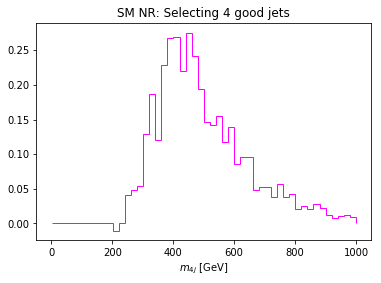

In [29]:
plt.hist(miniNtuple['4jets_m4j'],bins=50,range=(1,1000),
         histtype='step',color='magenta',weights=miniNtuple.mc_sf)
plt.xlabel('$m_{4j}$ [GeV]')
plt.title(title+': Selecting 4 good jets')
plt.savefig('{}/fourGoodJets_m_hh.pdf'.format(figDir))
plt.show()

In [30]:
num = miniNtuple.loc[miniNtuple['4jets_m4j'] == 0,'mc_sf']

np.sum(num) / miniNtuple.mc_sf.sum()

0.0

Ok, the number that I'm seeing here is 93%, where as the number from the paper looks closer to 95%, but pas mal, I also don't have an error bar on this number rn, and my statistics are not as good as they could be when I run over all 18 files instead of just the one.

**Look at the mass plane just after selecting these 4 jets**

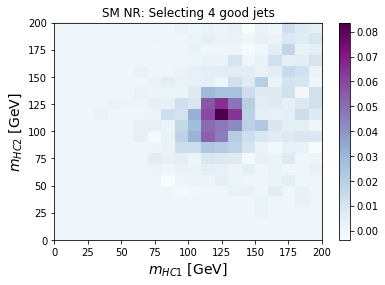

In [31]:
mask = miniNtuple['4jets_m4j'] != 0

m1s = np.concatenate([miniNtuple.loc[mask,'pair{}_HC1_m'.format(i)] for i in range(3)],axis=0)
m2s = np.concatenate([miniNtuple.loc[mask,'pair{}_HC2_m'.format(i)] for i in range(3)],axis=0)

ws = np.concatenate([miniNtuple.loc[mask,'mc_sf']]*3,axis=0)/3

plt.hist2d(m1s, m2s,
           bins=20,range=[(0,200)]*2,cmap=cmap_m,
           weights=ws)
plt.colorbar()

plt.xlabel('$m_{HC1}$ [GeV]',fontsize=14)
plt.ylabel('$m_{HC2}$ [GeV]',fontsize=14)

plt.title(title+': Selecting 4 good jets')
plt.savefig('{}/fourGoodJets_massplane.pdf'.format(figDir))
plt.show()

Ok, for the signal after you select the 4 b-tagged jets, since we actually have a resonance, we see a peak at around the Higgs mass.

## Step 2

Mass dependent $\Delta R$ cut. 

Since $\Delta R$ between the constitents acts as a proxy for the mass, I think it's also important to keep an eye on how we're sculpting this distribution as well!


In [32]:
# For overlaying these curves!
m4j_min, m4j_max = 1, 1250 # GeV
m4j = np.linspace(m4j_min, m4j_max) 

Rmin_lead = 360 / m4j - 0.5
Rmax_lead = 653 / m4j + 0.475

Rmin_subl = 235 / m4j
Rmax_subl = 875 / m4j + 0.35

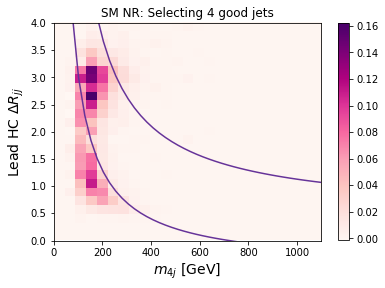

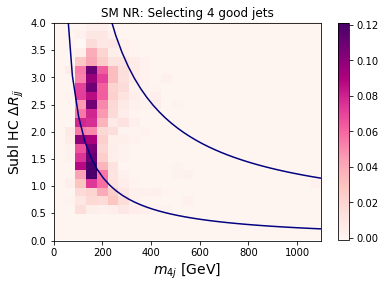

In [33]:
m4j_x3 = np.concatenate([miniNtuple.loc[mask,'4jets_m4j']]*3,axis=0)/3

dRjj1s = np.concatenate([miniNtuple.loc[mask,'pair{}_HC1_dRjj'.format(i)] for i in range(3)],axis=0)
dRjj2s = np.concatenate([miniNtuple.loc[mask,'pair{}_HC2_dRjj'.format(i)] for i in range(3)],axis=0)

for dRjj,HC_ID, dRmin, dRmax, c, i in zip([dRjj1s,dRjj2s],['Lead','Subl'],
                                          [Rmin_lead,Rmin_subl],[Rmax_lead,Rmax_subl],
                                          [c_lead,c_subl],[1,2]):

    plt.figure()
    plt.hist2d(m4j_x3, dRjj,
               bins=25,range=[(0,1100),(0,4)],
               cmap=cmap_dr,weights=ws)
    plt.colorbar()

    plt.xlabel('$m_{4j}$ [GeV]',fontsize=14)
    plt.ylabel(HC_ID+' HC $\Delta R_{jj}$',fontsize=14)

    plt.title(title+': Selecting 4 good jets')

    # Overlay the curves that we're cutting on for dRjj
    plt.plot(m4j,dRmin, c)
    plt.plot(m4j,dRmax, c)
    
    plt.savefig('{}/fourGoodJets_HC{}_dRjj_m4j.pdf'.format(figDir,i))
    
plt.show()

This looks spread out right now, because we're plotting all three of the possible combinations, but it's cool because you can *visually see* which combinations will get rejected by applying this cut!

**Implementation**

First write functions for the dRjj cuts

In [34]:
def lead_dRjj_cut(dRjj, m4j):
    '''
    Given the opening angle of the constituents of the leading HC 
    (ordered by the SS of the constituents), return true or false
    for whether or not the pairing is valid, given the 4 jet 
    invariant mass.
    
    Inputs:
    - dRjj: A np array of shape (nEvts,) # nPairings)
    - m4j: A np array of shape (nEvs,) for broadcasting
    '''
    
    validPairs = np.ones_like(dRjj).astype(bool)
    
    # low mass cut
    validPairs[(m4j < 1250) & (dRjj < 360 / m4j - 0.5)] = False
    validPairs[(m4j < 1250) & (dRjj > 652.863 / m4j + 0.474449)] = False
    
    # high mass cut
    validPairs[(m4j > 1250) & (dRjj < 0)] = False
    validPairs[(m4j > 1250) & (dRjj > 0.9967394)] = False
  
    return validPairs

def subl_dRjj_cut(dRjj, m4j):
    '''
    dR cut for the subleading HC 
    '''
    
    validPairs = np.ones_like(dRjj).astype(bool)
    
    # low mass cut
    validPairs[(m4j < 1250) & (dRjj < 235.242 / m4j + 0.0162996)] = False
    validPairs[(m4j < 1250) & (dRjj > 874.890 / m4j + 0.347137)] = False
    
    # high mass cut
    validPairs[(m4j > 1250) & (dRjj < 0)] = False
    validPairs[(m4j > 1250) & (dRjj > 1.047049)] = False
  
    return validPairs
    

Secondly, write the functions that define the possible pairings. Since I want to keep track of the possible pairings for each event, I don't want to use the flattened versions of the arrays at this point.

In [35]:
hc1_cols = ['pair{}_HC1_dRjj'.format(i) for i in range(3)]
hc2_cols = ['pair{}_HC2_dRjj'.format(i) for i in range(3)]

lead_dR_arr = miniNtuple.loc[mask,hc1_cols].values
subl_dR_arr = miniNtuple.loc[mask,hc2_cols].values

m4j_arr = miniNtuple.loc[mask,'4jets_m4j'].values

In [36]:
lead_pair_mask = np.vstack([lead_dRjj_cut(lead_dR_arr[:,i],m4j_arr) for i in range(3)]).T
subl_pair_mask = np.vstack([subl_dRjj_cut(subl_dR_arr[:,i],m4j_arr) for i in range(3)]).T
lead_pair_mask.shape

(2703, 3)

For the event to be valid, both pairs have to be valid

In [37]:
pair_mask = lead_pair_mask & subl_pair_mask

**Number of possible pairings**

In [38]:
nValidPairs = pair_mask.sum(axis=1)

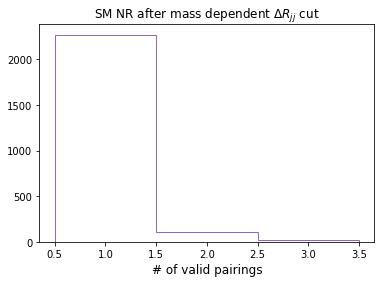

In [39]:
plt.hist(nValidPairs,3,(0.5,3.5),color=c_evt,histtype='step')
plt.xlabel('# of valid pairings',fontsize=12)
plt.title(title+' after mass dependent $\Delta R_{jj}$ cut')
plt.savefig('{}/dRjj_validPairings.pdf'.format(figDir))
plt.show()

So this cut does a very good job at isolating our SM signal.

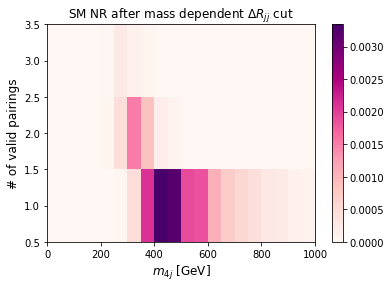

In [40]:
plt.hist2d(m4j_arr,nValidPairs, bins=(20,3),range=((0,1000),(0.5,3.5)), 
         cmap=cmap_dr,weights=miniNtuple.loc[mask,'mc_sf'],normed=True)
plt.xlabel('$m_{4j}$ [GeV]',fontsize=12)
plt.ylabel('# of valid pairings',fontsize=12)
plt.colorbar()
plt.title(title+' after mass dependent $\Delta R_{jj}$ cut')
plt.savefig('{}/dRjj_validPairings_vs_m4j.pdf'.format(figDir))
plt.show()

**2d mass plane**

The question that we're trying to answer is how this pairing sculpts the mass distribution. So to answer this question, I want to plot the 2d mass plane again.

I think now I'm going to want to make a weighted histogram to give less weight to the events that have fewer valid pairings (but I could not do this also - if desired).

In [41]:
np.unique(nValidPairs,return_counts=True)

(array([0, 1, 2, 3]), array([ 308, 2270,  103,   22]))

In [42]:
m1_cols = ['pair{}_HC1_m'.format(i) for i in range(3)]
m2_cols = ['pair{}_HC2_m'.format(i) for i in range(3)]

m1_drcut = miniNtuple.loc[mask,m1_cols].values[pair_mask]
m2_drcut = miniNtuple.loc[mask,m2_cols].values[pair_mask]

In [43]:
# Note: nValidParis will be 0 for cases where there are no valid pairs, but
# I'll be masking these values anyways, to I don't have to worry about the warning 
base_w = np.nan_to_num(miniNtuple.loc[mask,'mc_sf'].values / nValidPairs)

ws_drcut = np.vstack([base_w]*3).T
ws_drcut = ws_drcut[pair_mask]


/cvmfs/sft.cern.ch/lcg/views/LCG_94python3/x86_64-slc6-gcc8-opt/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [44]:
plt.hist2d(m1_drcut, m2_drcut, bins=20, range=[(0,200)]*2, cmap='BuPu',
           weights=ws_drcut)
plt.colorbar()

plt.xlabel('$m_{HC1}$ [GeV]',fontsize=14)
plt.ylabel('$m_{HC2}$ [GeV]',fontsize=14)

plt.title(title+' after the $\Delta R_{jj}$ cut')
plt.savefig('{}/dRjj_massplane.pdf'.format(figDir))
plt.show()

**Full mass plane**
- Note, there could be events at this point where we don't have any valid mass pair, so this step is also essentially a cut in the analysis.

In [45]:
miniNtuple['4jets_m4j'].shape

(28730,)

In [46]:
miniNtuple.loc[mask,'4jets_m4j'].shape

(2703,)

In [47]:
nValidPairs.shape

(2703,)

In [48]:
plt.hist(miniNtuple.loc[mask,'4jets_m4j'],bins=100,range=(1,1200),
         histtype='step',color='magenta', 
         label='4 b-jets $p_T > 40$ GeV, $|\eta| < 2.5$',
         weights=miniNtuple.loc[mask,'mc_sf'])
plt.hist(miniNtuple.loc[mask,'4jets_m4j'][nValidPairs!=0],
         bins=50,range=(1,1000),
         histtype='step',color='C0', 
         label='Mass dependent $\Delta R_{jj}$ cut',
         weights=miniNtuple.loc[mask,'mc_sf'][nValidPairs!=0])

plt.xlabel('$m_{4j}$ [GeV]',fontsize=14)
plt.legend()
plt.title(title)
plt.savefig('{}/dRjj_m_hh.pdf'.format(figDir))
plt.show()

## Step 3: Apply the pairing algorithm to define the HC pairing

The formula for $D_{hh}$ from [the paper](https://arxiv.org/abs/1804.06174) is 

$$D_{hh} = \frac{|m_{2j}^{lead} - \frac{120}{100} m_{2j}^{subl}|}{\sqrt{1 + (\frac{120}{100})^2}}$$

So the good news is that since I've already stored the masses for all of the HCs, I'm setup to compute this right now!

**Note:** After this step, I can compare with what Beojean has in his framework!

In [49]:
miniNtuple.columns

Index(['nresolvedJets', 'resolvedJets_E', 'resolvedJets_pt',
       'resolvedJets_phi', 'resolvedJets_eta', 'resolvedJets_MV2c10',
       'resolvedJets_HadronConeExclTruthLabelID',
       'resolvedJets_is_MV2c10_FixedCutBEff_70', 'nmuon', 'muon_pt',
       'muon_eta', 'muon_phi', 'muon_m', 'muon_EnergyLoss',
       'resolvedJets_SF_MV2c10_FixedCutBEff_70', 'mcChannelNumber',
       'mcEventWeight', '4jets_m4j', 'mc_sf', 'pair0_HC1_m', 'pair0_HC1_dRjj',
       'pair0_HC2_m', 'pair0_HC2_dRjj', 'pair1_HC1_m', 'pair1_HC1_dRjj',
       'pair1_HC2_m', 'pair1_HC2_dRjj', 'pair2_HC1_m', 'pair2_HC1_dRjj',
       'pair2_HC2_m', 'pair2_HC2_dRjj'],
      dtype='object')

**Implementation:** Calculate *all* of the $D_{hh}$, and then set the masked values to an unreasonably large number so you don't choose them!

In [50]:
Dhhs = []

for pair in range(3):
    
    m1_key = 'pair{}_HC1_m'.format(pair)
    m2_key = 'pair{}_HC1_m'.format(pair)
    
    Dhh_key = 'pair{}_Dhh'.format(pair)
    
    s = 120 / 100
    Dhhs.append(np.abs(miniNtuple.loc[mask,m1_key] - s * miniNtuple.loc[mask,m2_key]) / np.sqrt(1 + s**2))  
    

In [51]:
all_Dhhs = np.vstack(Dhhs).T

In [52]:
all_Dhhs

array([[17.75798768, 27.94449581, 23.17903532],
       [34.29178305, 66.02044405, 53.42251105],
       [65.3934858 , 14.74872496, 43.59262588],
       ...,
       [32.4255532 , 27.18653917, 33.90790718],
       [26.60267495, 50.07872209, 29.95187917],
       [82.01656751, 72.36198259, 15.31230805]])

**Visualizing what this cut is doing**

Let's plot the $D_{hh}$ distribution for the different numbers of possible pairings to get an intuition for what this looks like, and how it might be sculpting our results.

In [53]:
myRange=(0,25)

for i,c in zip([1,2,3],['C6','C4','C2']):
    
    nPairMask = (nValidPairs==i)
    
    Dhh_nSel = all_Dhhs[nPairMask]
    pair_nSel = pair_mask[nPairMask]
    
    dhh = Dhh_nSel[pair_nSel]
    
    ws_nSel = np.vstack([base_w]*3).T
    ws_nSel = ws_nSel[nPairMask][pair_nSel]
    
    plt.hist(dhh,bins=25,range=myRange,color=c, histtype='step',
             label='{} valid pair'.format(i), density=True, 
             weights=ws_nSel)
    
plt.title(title)
plt.xlabel('$D_{hh}$',fontsize=14)
plt.legend()
plt.savefig('{}/dRjj_Dhh.pdf'.format(figDir))
plt.show()

- I decided to normalize all of the histograms so I wasn't overwhelmed by the events with only one possible pairing.
- I thought it seemed interesting that the distribution with 3 valid pairs was quite a bit more spread out than I was anticipating. I think it will be interesting to see how this plot evolves with more stats!


In [54]:
np.min(all_Dhhs),np.max(all_Dhhs)

(5.098643016199555, 391.050883350914)

Ok, so if I set invalid pairs to 10x the max, then I'll not choose these in my minimization procedure

In [55]:
masked_val = np.ceil(10*np.max(all_Dhhs)).astype(int)

In [56]:
masked_val

3911

In [57]:
~pair_mask

array([[False,  True, False],
       [ True,  True,  True],
       [ True, False,  True],
       ...,
       [ True, False,  True],
       [ True,  True,  True],
       [ True,  True, False]])

In [58]:
all_Dhhs[~pair_mask] = masked_val

In [59]:
best_idx = np.argmin(all_Dhhs,axis=1)
best_idx.shape

(2703,)

In [60]:
np.unique(best_idx,return_counts=True)

(array([0, 1, 2]), array([1036,  857,  810]))

**Use this min $D_{hh}$ to determin the "correct" pairing** 

What I mean is, I want to use this to choose which $m_{HC1}$ and $m_{HC2}$ to use! 


In [61]:
# m_HC1 = np.take(miniNtuple.loc[mask,m1_cols].values,best_idx,axis=1)[nValidPairs>0]
# m_HC2 = np.take(miniNtuple.loc[mask,m2_cols].values,best_idx)[nValidPairs>0]

In [62]:
m1_arrs = miniNtuple.loc[mask,m1_cols].values
m2_arrs = miniNtuple.loc[mask,m2_cols].values

m_HC1 = np.array([ms[i] for i,ms,nPair in zip(best_idx,m1_arrs,nValidPairs) if nPair != 0])
m_HC2 = np.array([ms[i] for i,ms,nPair in zip(best_idx,m2_arrs,nValidPairs) if nPair != 0])

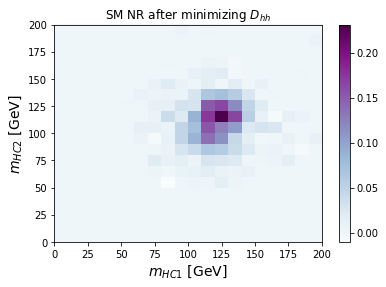

In [63]:
plt.hist2d(m_HC1, m_HC2, bins=20, range=[(0,200)]*2, cmap='BuPu',
           weights=miniNtuple.loc[mask,'mc_sf'][nValidPairs>0])
plt.colorbar()

plt.xlabel('$m_{HC1}$ [GeV]',fontsize=14)
plt.ylabel('$m_{HC2}$ [GeV]',fontsize=14)

plt.title(title+' after minimizing $D_{hh}$')
plt.savefig('{}/dhh_massplane.pdf'.format(figDir))
plt.show()

## Step 4: Validation

Ok, so now I have two separate ways to get the HC masses after this step
1. The `afterPairing` tree that I'm printing out from Beojean's miniNtuple
2. This implementation doing it myself starting from the miniNtuple.

But the ultimate test is... **do I get the same results with either method?**

So load in the tree made with Beojean's code to find out!

In [64]:
fDir = "../../hh4b-resolved-reconstruction/btagStudies/"
treeName = "afterPairing"
df = pd.DataFrame(root2array(fDir + microName, treeName, selection='ntag >= 4'))

In [65]:
df.head()

run_number  event_number  ntag  njets     mc_sf   event_m_hh  event_pt_hh  \
0      284500         58966     4      5  0.000489   778.645489   163.366541   
1      284500         54480     4      4  0.000578   686.620692    98.313699   
2      284500         58172     4      6  0.000035  1497.847496   149.767381   
3      284500         54916     4      6  0.000502   802.034701   370.723890   
4      284500         54059     4      4  0.000305   955.657544    40.238817   

   event_m_h1  event_E_h1  event_pT_h1     ...       event_angle_h2_j2  \
0  124.574851  937.474243   458.303306     ...                1.425994   
1  128.454230  377.201126   330.728674     ...                1.112445   
2  124.416416  536.273621   519.870861     ...                1.747721   
3  131.535886  647.316269   602.738654     ...                1.045374   
4  134.472817  498.524567   479.391059     ...                1.330752   

   event_tag_h1_j1  event_tag_h1_j2  event_tag_h2_j1  event_tag_h2_j2  \
0             True             True             True             True   
1             True             True             True             True   
2             True             True             True             True   
3             True             True             True             True   
4             True             True             True             True   

    rwgt_pT_4   rwgt_pT_2  rwgt_eta_i  rwgt_dRjj_1  rwgt_dRjj_2  
0  141.869690  182.019043    1.156026     0.520411     0.532824  
1   66.773712  191.945648    0.870618     0.714470     0.810107  
2  152.308727  291.094177    1.083034     0.464294     0.520504  
3   79.313148  170.346268    0.311849     0.443727     1.014829  
4  115.396439  281.196686    0.232799     0.530333     0.605385  

[5 rows x 50 columns]

In [66]:
#assert True == False

In [67]:
for i, (evt,mc_sf) in df[['event_number','mc_sf']].iterrows():
    print("Evt {}: micro_sf = {}, my_sf = {}".format(int(evt),mc_sf, miniNtuple.loc[evt,'mc_sf']))
    break

Evt 58966: micro_sf = 0.0004890677098337916, my_sf = 0.0004890677098337915


Yey! My answers match exactly for the mc_sf column. 
The only last step is making sure that I have the same events in my miniNtuple with the masks and cuts that I have in the micro-Ntuple 

In [68]:
mini_evts = np.sort(miniNtuple[mask].index[nValidPairs>0])

In [69]:
micro_evts = np.sort(df['event_number'])

In [70]:
mini_evts

array([    3,    13,    24, ..., 61967, 61980, 61994])

In [71]:
micro_evts

array([    3,    13,    24, ..., 61967, 61980, 61994])

In [72]:
mini_evts.shape

(2395,)

In [73]:
micro_evts.shape

(2395,)

Ok, so there are 9 events that my selection is **keeping** that Beojean's is throwing out, what do these events look like???

In [74]:
for i in mini_evts:
    if i not in micro_evts:
        print(i)

In [75]:
ievt = 58408
miniNtuple.loc[ievt]

nresolvedJets                                                                              5
resolvedJets_E                             [147.99614, 242.27943, 116.17073, 170.39767, 1...
resolvedJets_pt                            [129.74577, 112.277985, 54.182583, 51.45389, 2...
resolvedJets_phi                           [1.9453318, -1.745708, 0.82382923, -0.5048931,...
resolvedJets_eta                           [0.5129101, -1.4012845, 1.3942357, -1.8663015,...
resolvedJets_MV2c10                        [0.97721463, 0.9428447, 0.94763386, 0.9898548,...
resolvedJets_HadronConeExclTruthLabelID                                      [5, 5, 5, 5, 0]
resolvedJets_is_MV2c10_FixedCutBEff_70                                       [1, 1, 1, 1, 0]
nmuon                                                                                      1
muon_pt                                                                            [27.9702]
muon_eta                                                              

In [76]:
miniNtuple.loc[ievt,'resolvedJets_MV2c10']

array([ 0.97721463,  0.9428447 ,  0.94763386,  0.9898548 , -0.6552387 ],
      dtype=float32)

In [77]:
im4j = miniNtuple.loc[ievt,'4jets_m4j']

lRmin = 360 / im4j - 0.5
lRmax = 652.863 / im4j + 0.474449

sRmin = 235.242 / im4j + 0.0162996
sRmax = 874.890 / im4j + 0.347137

print('lead: {} < dRjj < {}'.format(lRmin,lRmax))
print('subl: {} < dRjj < {}'.format(sRmin,sRmax))

lead: 0.010722733764406467 < dRjj < 1.4006489337045327
subl: 0.3500313703783514 < dRjj < 1.5883209237309488


In [78]:
im4j

704.8834449693128

In [79]:
miniNtuple.loc[ievt,['pair0_HC1_dRjj','pair0_HC2_dRjj']]

pair0_HC1_dRjj    3.41628
pair0_HC2_dRjj    3.79703
Name: 58408, dtype: object

In [80]:
miniNtuple.loc[ievt,['pair1_HC1_dRjj','pair1_HC2_dRjj']]

pair1_HC1_dRjj    3.22232
pair1_HC2_dRjj    3.51193
Name: 58408, dtype: object

In [81]:
miniNtuple.loc[ievt,['pair2_HC1_dRjj','pair2_HC2_dRjj']]

pair2_HC1_dRjj    1.30257
pair2_HC2_dRjj    1.42636
Name: 58408, dtype: object

In [82]:
miniNtuple.loc[ievt,['pair0_HC1_m','pair0_HC2_m']]

pair0_HC1_m    353.811
pair0_HC2_m    332.742
Name: 58408, dtype: object

In [83]:
print('Numbers from Beojean\'s code')
print('lead: {} < dRjj < {}'.format(360/im4j-0.5, 652.863/im4j+0.474449))
print('subl: {} < dRjj < {}'.format(235.242/im4j+0.0162996, 874.890/im4j+0.347137))

Numbers from Beojean's code
lead: 0.010722733764406467 < dRjj < 1.4006489337045327
subl: 0.3500313703783514 < dRjj < 1.5883209237309488


In [84]:
#miniNtuple.loc[ievt,'nValidPairs']

In [85]:
miniNtuple['nValidPairs'] = 0
miniNtuple.loc[mask,'nValidPairs'] = nValidPairs

In [86]:
nValidPairs.shape

(2703,)

**Another check:** What events are in Beojean's code that are *not* in mine?

In [87]:
for i in micro_evts:
    if i not in mini_evts:
        print(i)

In [88]:
miniNtuple.loc[mask,'nValidPairs'] = nValidPairs

In [89]:
ievt = 58408
miniNtuple.loc[ievt]

nresolvedJets                                                                              5
resolvedJets_E                             [147.99614, 242.27943, 116.17073, 170.39767, 1...
resolvedJets_pt                            [129.74577, 112.277985, 54.182583, 51.45389, 2...
resolvedJets_phi                           [1.9453318, -1.745708, 0.82382923, -0.5048931,...
resolvedJets_eta                           [0.5129101, -1.4012845, 1.3942357, -1.8663015,...
resolvedJets_MV2c10                        [0.97721463, 0.9428447, 0.94763386, 0.9898548,...
resolvedJets_HadronConeExclTruthLabelID                                      [5, 5, 5, 5, 0]
resolvedJets_is_MV2c10_FixedCutBEff_70                                       [1, 1, 1, 1, 0]
nmuon                                                                                      1
muon_pt                                                                            [27.9702]
muon_eta                                                              

In [90]:
nValidPairs

array([2, 0, 1, ..., 1, 0, 1])

In [91]:
df[df.event_number == ievt]

run_number  event_number  ntag  njets     mc_sf  event_m_hh  \
1602      284500         58408     4      4  0.000896  704.883445   

      event_pt_hh  event_m_h1  event_E_h1  event_pT_h1     ...       \
1602    39.086354  118.265291  496.895948   157.141338     ...        

      event_angle_h2_j2  event_tag_h1_j1  event_tag_h1_j2  event_tag_h2_j1  \
1602           1.694143             True             True             True   

      event_tag_h2_j2  rwgt_pT_4   rwgt_pT_2  rwgt_eta_i  rwgt_dRjj_1  \
1602             True  54.182583  112.277985    1.289441     1.302575   

      rwgt_dRjj_2  
1602      1.42636  

[1 rows x 50 columns]

In [92]:
df.loc[1602]

run_number                284500
event_number               58408
ntag                           4
njets                          4
mc_sf                0.000896039
event_m_hh               704.883
event_pt_hh              39.0864
event_m_h1               118.265
event_E_h1               496.896
event_pT_h1              157.141
event_eta_h1             -1.7876
event_phi_h1            -1.25918
event_m_h2               119.661
event_E_h2               264.167
event_pT_h2              160.861
event_eta_h2             0.92956
event_phi_h2             1.63707
event_m_h1_j1            7.96011
event_E_h1_j1            254.617
event_pT_h1_j1           78.1498
event_eta_h1_j1         -1.84933
event_phi_h1_j1        -0.522617
event_angle_h1_j1        1.53097
event_m_h1_j2            15.6512
event_E_h1_j2            242.279
event_pT_h1_j2           112.278
event_eta_h1_j2         -1.40128
event_phi_h1_j2         -1.74571
event_angle_h1_j2        1.61062
event_m_h2_j1            15.4282
event_E_h2

In [93]:
event_pT_h1_j1 = 78.1498
event_pT_h1_j2 = 112.278

event_pT_h1_j1 + event_pT_h1_j2

190.4278

In [94]:
event_pT_h2_j1 = 129.746
event_pT_h2_j2 = 54.1826

event_pT_h2_j1 + event_pT_h2_j2

183.92860000000002

In [95]:
j21, j22 = TLorentzVector(), TLorentzVector()

j21.SetPtEtaPhiE(*df.loc[1356,['event_pT_h2_j1','event_eta_h2_j1','event_phi_h2_j1','event_E_h2_j1']].values)
j22.SetPtEtaPhiE(*df.loc[1356,['event_pT_h2_j2','event_eta_h2_j2','event_phi_h2_j2','event_E_h2_j2']].values)

In [96]:
j21.DeltaR(j22)

0.7794834994153282

Ok, so it is not something wrong with the python implementation of the DeltaR function :)

In [97]:
miniNtuple.columns

Index(['nresolvedJets', 'resolvedJets_E', 'resolvedJets_pt',
       'resolvedJets_phi', 'resolvedJets_eta', 'resolvedJets_MV2c10',
       'resolvedJets_HadronConeExclTruthLabelID',
       'resolvedJets_is_MV2c10_FixedCutBEff_70', 'nmuon', 'muon_pt',
       'muon_eta', 'muon_phi', 'muon_m', 'muon_EnergyLoss',
       'resolvedJets_SF_MV2c10_FixedCutBEff_70', 'mcChannelNumber',
       'mcEventWeight', '4jets_m4j', 'mc_sf', 'pair0_HC1_m', 'pair0_HC1_dRjj',
       'pair0_HC2_m', 'pair0_HC2_dRjj', 'pair1_HC1_m', 'pair1_HC1_dRjj',
       'pair1_HC2_m', 'pair1_HC2_dRjj', 'pair2_HC1_m', 'pair2_HC1_dRjj',
       'pair2_HC2_m', 'pair2_HC2_dRjj', 'nValidPairs'],
      dtype='object')

In [98]:
sort_pts  = miniNtuple[ievt,'resolvedJets_pt']
sort_etas = miniNtuple[ievt,'resolvedJets_pt']
sort_phis = miniNtuple[ievt,'resolvedJets_pt']
sort_Es   =miniNtuple[ievt,'resolvedJets_pt']

KeyError: (58408, 'resolvedJets_pt')